# Understanding Neural Nets Using Micrograd

Neural nets are mathematical expressions that take input as the data, the weights and parameters. They contain a mathematical expression for the forward pass and a loss function that measures the accuracy of the predictions. We try to minimize the loss by using backpropagation. Backpropagation calculates the gradients and maniputales them to minimize the loss. We do this iteratively by using gradient descent. 

In [8]:
from micrograd.engine import Value
import random
from graphviz import Digraph
import math
import matplotlib.pyplot as plt

### Micrograd code: Value and Operations

In [9]:
class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self.grad = 0
        # internal variables used for autograd graph construction
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op # the op that produced this node, for graphviz / debugging / etc

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(x) - math.exp(-x)) / (math.exp(x) + math.exp(-x))
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

### Defining Elements of a Multi Layered Perceptron

In [10]:
class Neuron(): # replicating a neuron

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        return act.tanh()
    
    def parameters(self): # here, we are collecting all of the parameters of the neuron, weights and biases
        return self.w + [self.b]
    
class Layer(): # replicating a layer that contains one or more neurons: dim, out (n neurons out)

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)] # we take a list of neurons and we output a certain amount of neurons (?)
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons] 
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self): # collecting all of the parameters of the neurons within the layer
        # return [p for neuron in self.neurons for p in neuron.parameters()] # list comprehension version (shorter)
        params = []
        for neuron in self.neurons:
            ps = neuron.parameters()
            params.extend(ps)
        return params
    
class MLP():

    def __init__(self, nin, nouts): # instead of taking one nout like in Layer, now we take a list of nouts. It defines the sizes of all the layers we want in a MLP
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))] # we iterate over the pairs and create Layer objects for them

    def __call__(self, x): # in the call funciton, we call the Layer objects sequentially
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        # return [p for layer in self.layers for p in layer.parameters()]  # list comprehension version (shorter)
        params = []
        for layer in self.layers:
            ps = layer.parameters()
            params.extend(ps)
        return params

    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"

### Manual Test

In [72]:
n = MLP(3, [3, 3, 1]) # n inputs, [dim layer 1, dim layer 2, dim layer 3 (output)]

input = [
    [3.0, 4.7, -3.2],
    [2.1, -7.0, 3.5],
    [4.4, -0.1, -0.2]
    ]

ys = [1.0, 1.0, 1.0] # desired targets 

In [73]:
len(n.parameters()) # total number of parameters of the MLP

28

In [74]:
ypred = [n(x) for x in input]
loss = sum((preds - ground_truth)**2 for ground_truth, preds in zip(ys, ypred))  # we build a loss function: MSE
print('Initial loss before any backpropagation: ', loss)

Initial loss before any backpropagation:  Value(data=5.075441514303303, grad=0)


In [75]:
[(preds - ground_truth)**2 for ground_truth, preds in zip(ys, ypred)] # individual losses, before summation

[Value(data=0.9966900686359034, grad=0),
 Value(data=3.134104258204319, grad=0),
 Value(data=0.9446471874630807, grad=0)]

In [80]:
print('Gradient of a neuron before backpropagation: ', n.layers[1].neurons[1].w[0].grad) # gradient
print('Value of a neuron before backpropagation: ', n.layers[1].neurons[1].w[0].data) # value of the neuron

Gradient of a neuron before backpropagation:  0
Value of a neuron before backpropagation:  0.4817246797012886


In [89]:
loss.backward() # doing a backward pass, or backpropagating, to initialize the gradients

In [90]:
'''
This lines of code check the gradient of a specific weight and value of a specific neuron, meaning how it influences the loss (negative of positive). 
If it is negative, increasing this weight will make the loss go down. If it is positive, decreasing this weight will make the loss go down.
'''
print('Gradient of a neuron after backpropagation: ', n.layers[1].neurons[1].w[0].grad) # gradient, which should have been initialized
print('Value of a neuron after backpropagation: ', n.layers[1].neurons[1].w[0].data) # value of the neuron, which should remain the same as before

Gradient of a neuron after backpropagation:  2.077048741898675
Value of a neuron after backpropagation:  0.3419065989699487


In [91]:
''' Gradient descent updates the values of the neurons, whereas the backward pass (backpropagation) updates the values of the gradients.
'''

for p in n.parameters(): # manual gradient descent. We modify p.data by a small step size in the direction of the gradient
    p.data += -0.1 * p.grad # the step is negative because we want to minimize the loss

In [92]:
print('New gradient of the neuron: ', n.layers[1].neurons[1].w[0].grad) # gradient, which should remain the same as it is not updated during gradient descent
print('New value of the neuron: ', n.layers[1].neurons[1].w[0].data) # new value of the neuron, which has decreased slightly, as we want the loss to decrease, and we want this particular neuron to decrease to make the loss go down

New gradient of the neuron:  2.077048741898675
New value of the neuron:  0.1342017247800812


In [93]:
ypred = [n(x) for x in input]
loss = loss = sum((preds - ground_truth)**2 for ground_truth, preds in zip(ys, ypred))  # we re-evaluate the loss after perfoming gradient descent. It should be lower than before
print('Loss after backproagation: ', loss)

Loss after backproagation:  Value(data=0.005206470950227208, grad=0)


In [94]:
ypred

[Value(data=0.9851158504398263, grad=0),
 Value(data=0.9294548331211895, grad=0),
 Value(data=0.9971168641831567, grad=0)]

In [95]:
n.parameters() # set of weights and biases that can predict our outputs

[Value(data=0.0307705957812636, grad=0.3381246169447579),
 Value(data=-0.3358279794309289, grad=-0.11139014250856669),
 Value(data=0.10968053308320837, grad=0.05159627846329973),
 Value(data=0.9535793731668752, grad=0.06954913208984739),
 Value(data=0.0016875512600868572, grad=-0.21882270856347344),
 Value(data=0.6889822239579183, grad=0.005000510248901554),
 Value(data=-0.8999166411648455, grad=0.009928930613027577),
 Value(data=-0.36485381321297905, grad=-0.049730572668618106),
 Value(data=-0.9828750434261316, grad=0.009196760821791041),
 Value(data=-0.8571937818742192, grad=-0.008611290168038103),
 Value(data=-0.10458599603543536, grad=0.003927191484754323),
 Value(data=0.26828796938922167, grad=0.002722051975035631),
 Value(data=-0.5984770051804751, grad=3.2001068577487515),
 Value(data=1.1324848816075759, grad=-2.304655929710785),
 Value(data=0.08340260552581089, grad=0.008674077016683612),
 Value(data=-0.09321394723541898, grad=4.04927371115404),
 Value(data=0.1342017247800812, g

### Automating the process

In [107]:
n = MLP(5, [10, 10, 1]) # nin, [dim layer 1, dim layer 2, dim layer 3 (output)]

inputs = [
    [3.0, 4.7, -3.2],
    [2.1, -7.0, 3.5],
    [4.4, -0.1, -0.2],
    [1.0, 1.0, -1.0]
    ]

ys = [1.0, -1.0, -1.0, 1.0] # desired targets (just random) before loss

In [109]:
len(n.parameters())

181

In [102]:
loss_values = []  
grads = []
params = []
for k in range(100):
    # 1. forward pass
    ypred = [n(x) for x in inputs]
    loss = sum((preds - ground_truth)**2 for ground_truth, preds in zip(ys, ypred)) 
    
    # 2. backward pass
    grads_values = []
    params_values = []
    for p in n.parameters():
        grads_values.append(p.grad)  # grads
        params_values.append(p.data)  # params
        p.grad = 0.0 # flush out gradients before each iteration

    grads.append(grads_values)
    params.append(params_values)

    loss.backward() # backward

    # 3. update step = gradient descent
    for p in n.parameters():
        p.data += -0.001 * p.grad
    
    loss_values.append(loss.data)

    print(k, loss.data)

0 8.65833784895872
1 8.398503523922674
2 8.137736896902776
3 7.872730550656069
4 7.59989519964698
5 7.31555163999883
6 7.016201569647206
7 6.698922853411368
8 6.361916243754827
9 6.005172933264072
10 5.631124839076649
11 5.245009886885681
12 4.854630538397467
13 4.469338247660893
14 4.098454112497681
15 3.7496975453084485
16 3.428209853342075
17 3.1363933503542922
18 2.8743679159661655
19 2.6406788287730816
20 2.432971112982144
21 2.2485036638861415
22 2.0844891857480805
23 1.9382936526705516
24 1.8075371493081107
25 1.6901311257600127
26 1.5842775850001147
27 1.4884475520607858
28 1.401350038884436
29 1.3218983666930333
30 1.249177743725512
31 1.18241606196608
32 1.1209586767915094
33 1.0642472360526036
34 1.011802255942729
35 0.9632089761420369
36 0.9181059820500366
37 0.876176102866552
38 0.8371391469561598
39 0.8007461002338134
40 0.7667744779942924
41 0.7350245799196525
42 0.7053164494657947
43 0.6774873818616722
44 0.6513898599725793
45 0.6268898251848558
46 0.6038652123373881
47

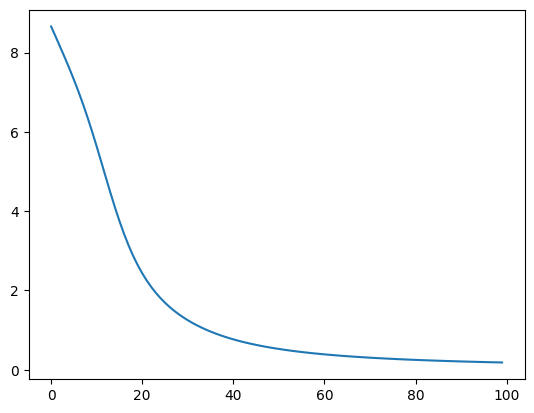

In [103]:
plt.plot(loss_values);

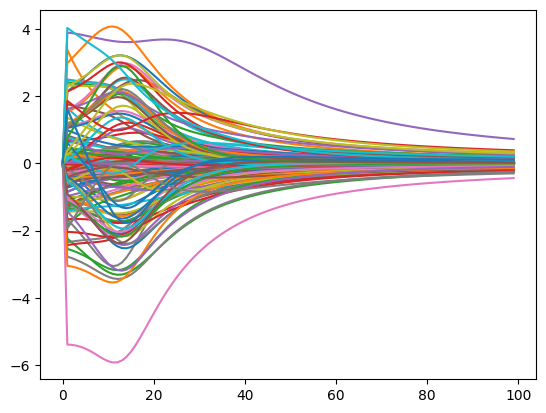

In [104]:
plt.plot(grads);

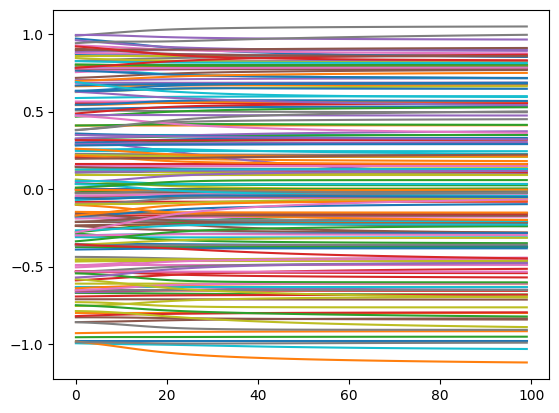

In [105]:
plt.plot(params);